In [1]:
import gpxpy
import gpxpy.gpx

import geopy
from geopy import distance

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
coords_1 = (47.238047, 7.659688)
coords_2 = (47.238050, 7.659700)

distance.distance(coords_1, coords_2).m
# (lat, lon) <- this is important

0.9678909147776563

### load & create metrics

In [73]:
gpx_file1 = open('data/cycling/cycling_250403.gpx', 'r')
gpx_file2 = open('data/cycling/cycling_250330.gpx', 'r')
gpx_file3 = open('data/cycling/cycling_250308.gpx', 'r')
gpx_file4 = open('data/cycling/cycling_250221.gpx', 'r')

files = [gpx_file1, gpx_file2, gpx_file3, gpx_file4]
dfs = []
for file in files:
    gpx = gpxpy.parse(file)
    
    cols = ['time', 'lat', 'lon', 'ele']
    lst = []
    
    
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lst.append([point.time,
                           point.latitude,
                           point.longitude,
                           point.elevation])
                #print('Point at ({0},{1}) -> {2} -> {3}'.format(point.latitude, point.longitude, point.elevation, point.time))
                
    df = pd.DataFrame(lst, columns = cols)

    df.loc[0, 'distance'] = 0
    df.loc[0, 'timedelta'] = 1
    df.loc[0, 'timefromstart'] = 0
    df.loc[0, 'distancefromstart'] = 0
    df.loc[0, 'slope'] = 0
    for i in range(1, len(df)):
        coords_1 = (df.loc[i-1, 'lat'], df.loc[i-1, 'lon'])
        coords_2 = (df.loc[i, 'lat'], df.loc[i, 'lon'])
        df.loc[i, 'distance'] = geopy.distance.distance(coords_1, coords_2).m
        
        df.loc[i, 'timedelta'] = (df.loc[i, 'time'] - df.loc[i-1, 'time']).seconds
        
        df.loc[i, 'timefromstart'] = (df.loc[i - 1, 'timefromstart'] + df.loc[i, 'timedelta'])
        
        df.loc[i, 'distancefromstart'] = (df.loc[i - 1, 'distancefromstart'] + df.loc[i, 'distance'])

        df.loc[i, 'slope'] = (df.loc[i, 'ele'] - df.loc[i - 1, 'ele'])/df.loc[i, 'distance']*100
    
    df['speed'] = df.distance/df.timedelta*3.6
    df['timedelta'] = df.timedelta.astype('int')
    df['speed_ma'] = df['speed'].rolling(2).mean()
    df['slope_ma'] = df['slope'].rolling(20).mean()
    df = df[0:-1]
    
    dfs.append(df)

C:\Users\JanAllemann\AppData\Local\Temp\ipykernel_26296\2306426348.py:42: RuntimeWarning: invalid value encountered in scalar divide
  df.loc[i, 'slope'] = (df.loc[i, 'ele'] - df.loc[i - 1, 'ele'])/df.loc[i, 'distance']*100


In [63]:
dfs[1]

,time,lat,lon,ele,distance,timedelta,timefromstart,distancefromstart,slope,speed,speed_ma,slope_ma
0,2025-02-21 13:07:05+00:00,47.238218,7.655736,417.200012,0.000000,1,0.0,0.000000,0.000000,0.000000,NaN,NaN
1,2025-02-21 13:07:06+00:00,47.238189,7.655725,417.399994,3.382326,1,1.0,3.382326,5.912550,12.176372,6.088186,NaN
2,2025-02-21 13:07:09+00:00,47.238204,7.655567,418.000000,12.147017,3,4.0,15.529342,4.939535,14.576420,13.376396,NaN
3,2025-02-21 13:07:10+00:00,47.238236,7.655545,418.000000,3.920484,1,5.0,19.449826,0.000000,14.113742,14.345081,NaN
4,2025-02-21 13:07:12+00:00,47.238307,7.655555,418.000000,7.877653,2,7.0,27.327479,0.000000,14.179776,14.146759,2.170417
...,...,...,...,...,...,...,...,...,...,...,...,...
1712,2025-02-21 14:34:14+00:00,47.238193,7.655534,425.399994,6.559302,1,5229.0,20387.718756,6.098117,23.613487,24.991847,1.800856
1713,2025-02-21 14:34:15+00:00,47.238162,7.655612,425.799988,6.855349,1,5230.0,20394.574104,5.834771,24.679255,24.146371,2.659609
1714,2025-02-21 14:34:16+00:00,47.238154,7.655713,425.799988,7.695505,1,5231.0,20402.269609,0.000000,27.703819,26.191537,2.659609
1715,2025-02-21 14:34:17+00:00,47.238169,7.655820,425.799988,8.247138,1,5232.0,20410.516748,0.000000,29.689698,28.696758,2.659609


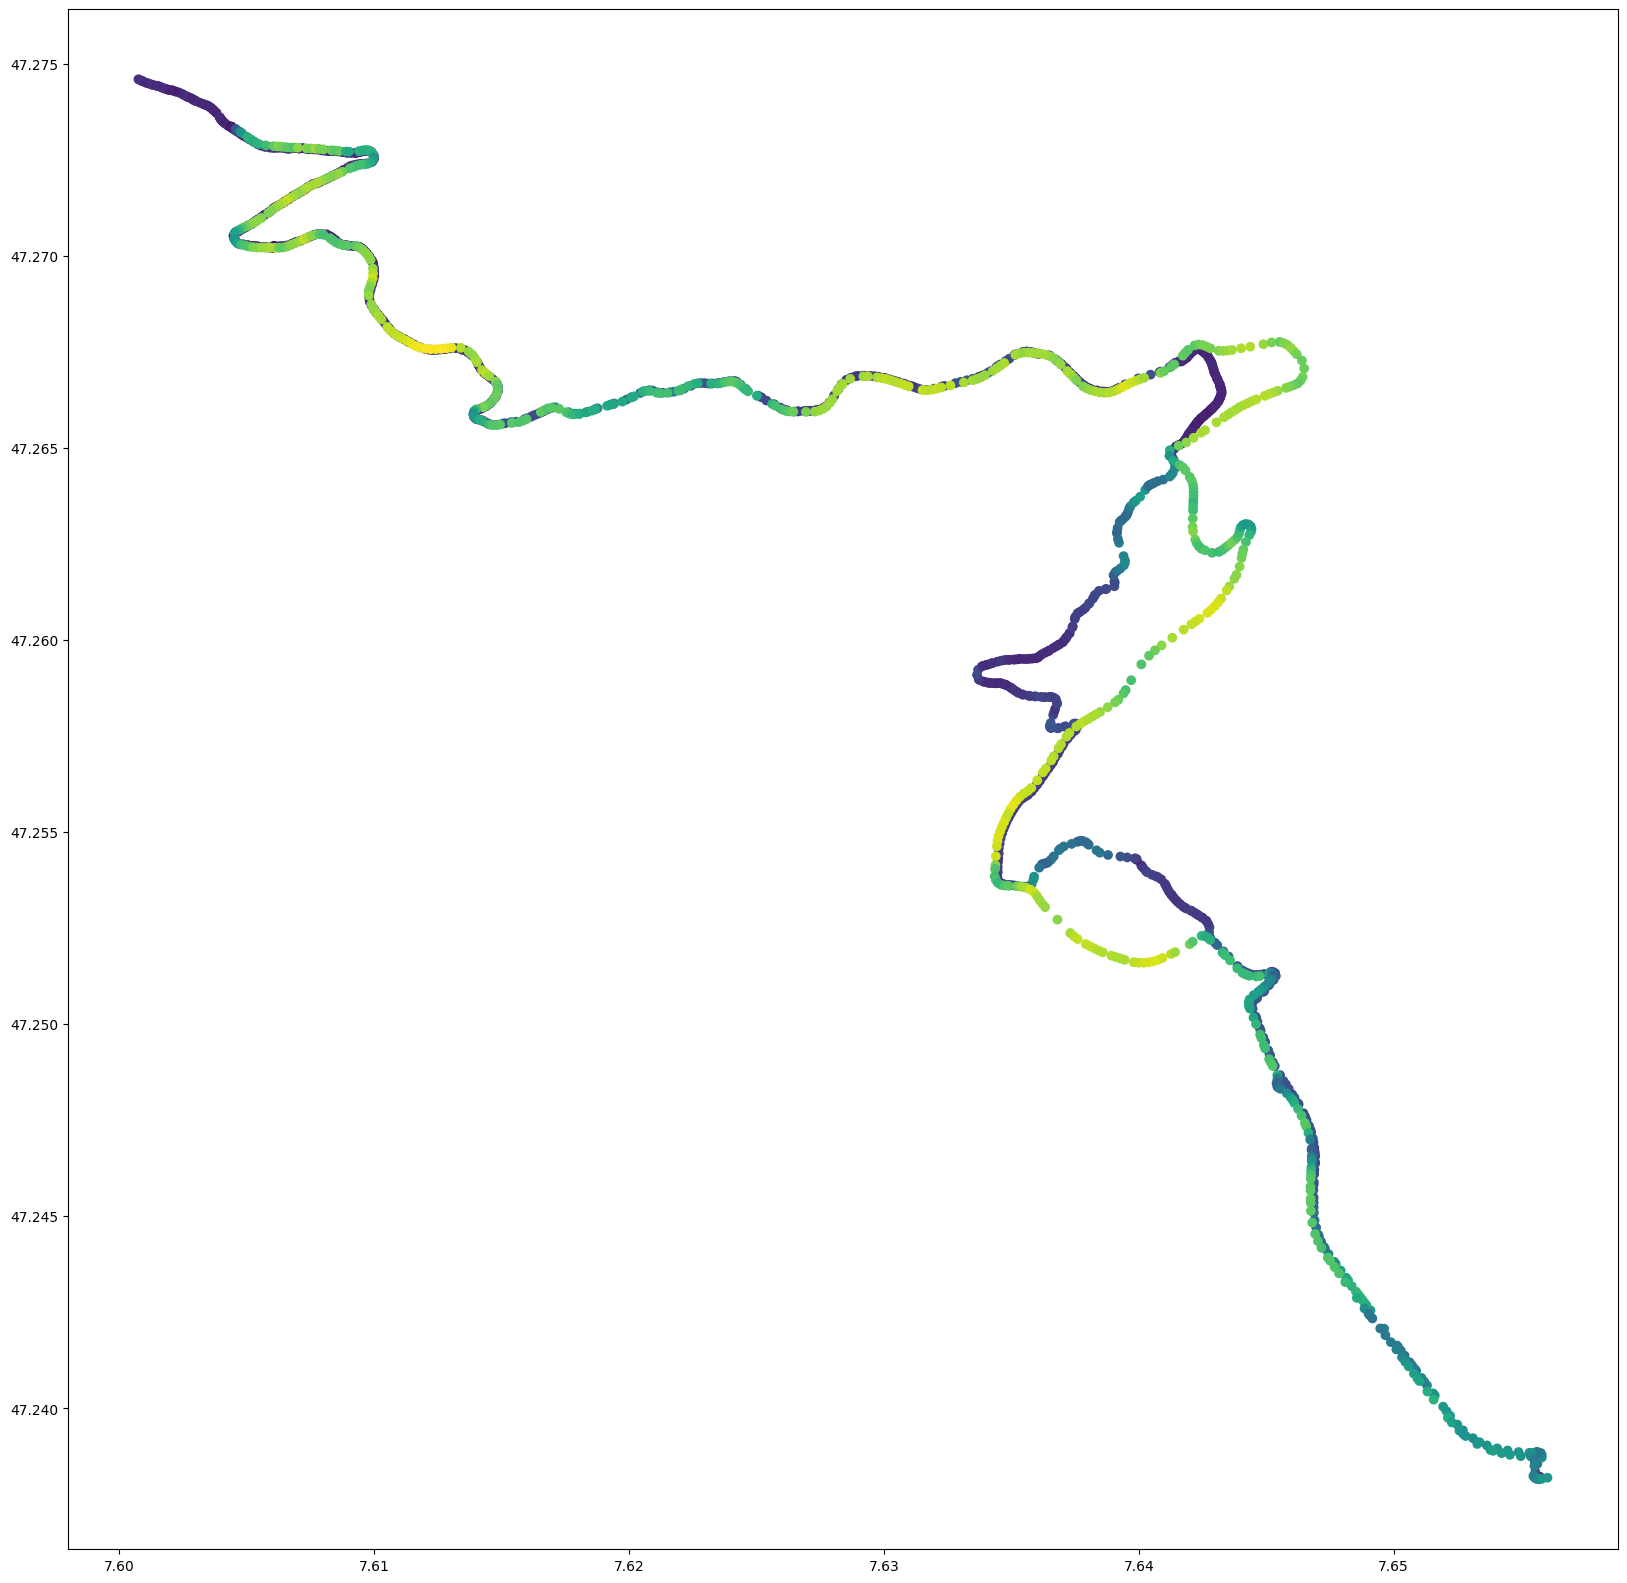

In [64]:
ax = plt.figure(figsize = (20, 20))

plt.scatter(dfs[1].lon, dfs[1].lat, c = dfs[1].speed)
plt.show()

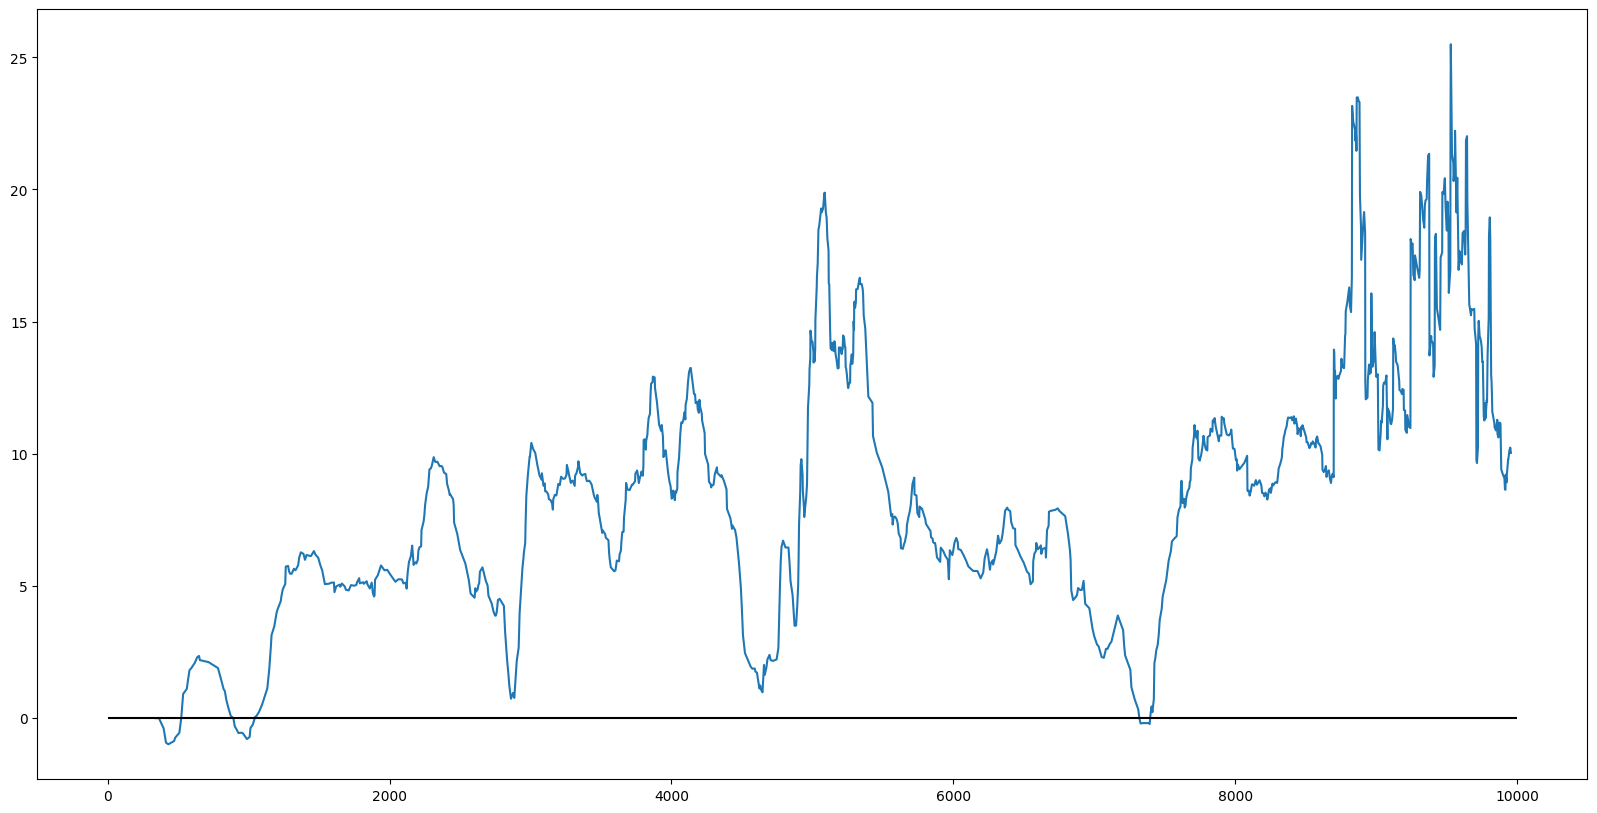

In [81]:
ax = plt.figure(figsize = (20, 10))
end = 1100

plt.plot(dfs[1].distancefromstart[:end], dfs[1].slope_ma[:end])
plt.hlines(0,0,10000, color = 'black')
plt.show()

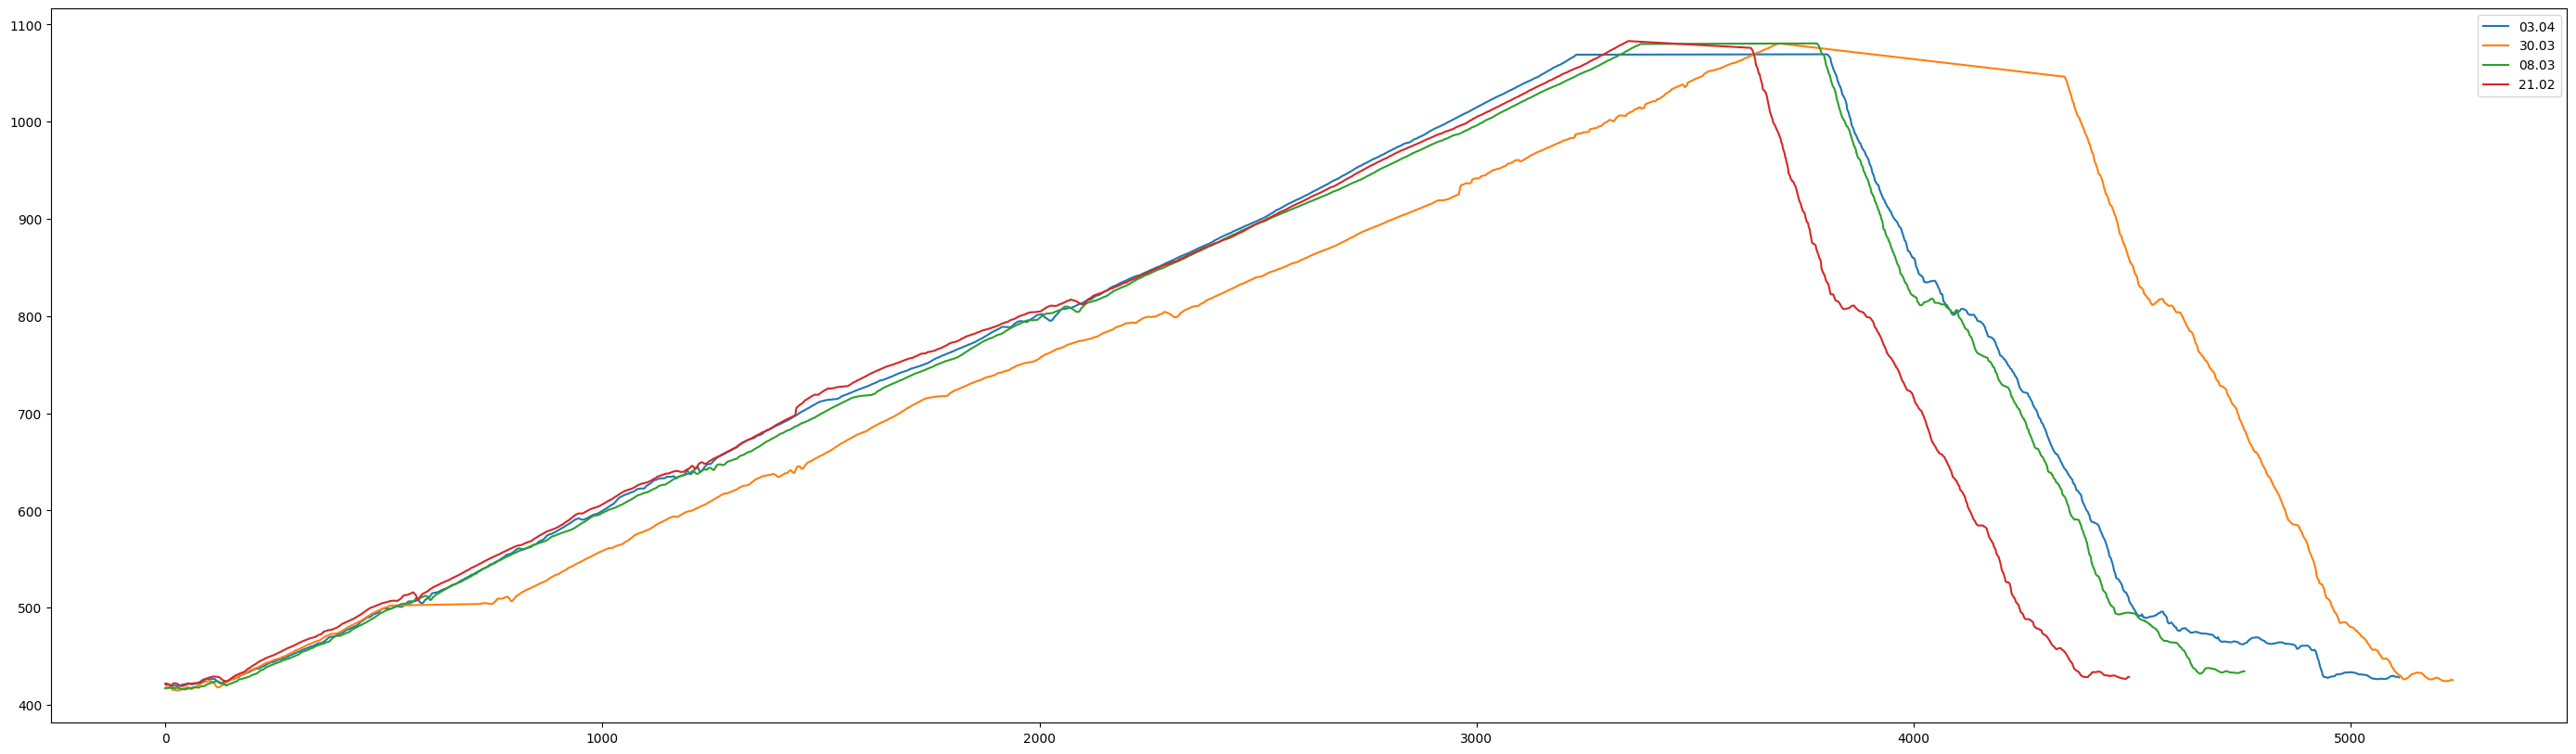

In [82]:
fig = plt.figure(figsize = (35,10))
ax = plt.axes()

ax.plot(dfs[0].timefromstart, dfs[0].ele, label = '03.04')
ax.plot(dfs[1].timefromstart, dfs[1].ele, label = '30.03')
ax.plot(dfs[2].timefromstart, dfs[2].ele, label = '08.03')
ax.plot(dfs[3].timefromstart, dfs[3].ele, label = '21.02')
plt.legend()
plt.show()